In [13]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


#### Load Data

Dataset generated with `preprocess_photometry.py` script.

In [5]:
name = "Sanity" # "Rico" "Skip" "Eva" "Private"

with open(f'../dopamine/Data/Expert_mice/all_processed_{name}.pkl', 'rb') as f:
    data = pickle.load(f)

#### Plot signal evolution through the preprocessing steps

In [18]:
def plot_preprocessing_panels(
    data,
    sessions=None,      # ['Skip', 'Eva', 'Rico']
    rois=None,       # [8, 9, 14]
    t_window=None,   # (0, 50)
    normalize_raw=False,     
    max_points=5000,
    save_dir=None,  
    dpi=150
):

    def _slice_by_time(t, arrs, window):
        if window is None:
            mask = np.ones_like(t, dtype=bool)
        else:
            t0, t1 = window
            mask = (t >= t0) & (t <= t1)
            if not np.any(mask):
                # Fallback to full if the window is outside range
                mask = np.ones_like(t, dtype=bool)
        sliced = []
        for a in arrs:
            # 1D arrays expected; adjust if needed
            sliced.append(a[mask])
        return t[mask], sliced

    def _maybe_decimate(t, arrs, maxn):
        if maxn is None or len(t) <= maxn:
            return t, arrs
        step = int(np.ceil(len(t) / maxn))
        idx = slice(0, None, step)
        return t[idx], [a[idx] for a in arrs]

    def _zscore(x):
        m = np.nanmean(x)
        s = np.nanstd(x)
        return (x - m) / (s + 1e-12)

    # Choose sessions
    sessions = list(data.keys()) if sessions is None else list(sessions)

    for session in sessions:
        results = data[session]
        time_interp = results['time_interp']     # (T, R)
        fluo_interp = results['fluo_interp']     # (T, 3, R) [iso, ca, td]
        fluo_F0     = results['fluo_F0']         # (T, 3, R)
        fluo_dFoF   = results['fluo_dFoF']       # (T, 3, R)
        corr_iso    = results['corrected_data_iso']   # (T, R)
        corr_td     = results['corrected_data_td']    # (T, R)
        corr_best   = results['corrected_data_best']  # (T, R)

        # Determine ROIs
        n_rois = time_interp.shape[1]
        roi_list = list(range(n_rois)) if rois is None else list(rois)
        # Clip any out-of-range ROI indices politely
        roi_list = [r for r in roi_list if 0 <= r < n_rois]
        if not roi_list:
            print(f"[{session}] No valid ROIs to plot.")
            continue

        for roi in roi_list:
            t_ref = time_interp[:, roi]
            iso_raw = fluo_interp[:, 0, roi]
            ca_raw  = fluo_interp[:, 1, roi]
            td_raw  = fluo_interp[:, 2, roi]
            f0_ca   = fluo_F0[:, 1, roi]
            dff_iso = fluo_dFoF[:, 0, roi]
            dff_ca  = fluo_dFoF[:, 1, roi]
            dff_td  = fluo_dFoF[:, 2, roi]
            c_iso   = corr_iso[:, roi]
            c_td    = corr_td[:, roi]
            c_best  = corr_best[:, roi]

            # Time slice
            t_plot, [iso_p, ca_p, td_p, f0_p, dff_iso_p, dff_ca_p, dff_td_p, c_iso_p, c_td_p, c_best_p] = \
                _slice_by_time(
                    t_ref,
                    [iso_raw, ca_raw, td_raw, f0_ca, dff_iso, dff_ca, dff_td, c_iso, c_td, c_best],
                    t_window
                )

            # Optional decimation for speed
            t_plot, [iso_p, ca_p, td_p, f0_p, dff_iso_p, dff_ca_p, dff_td_p, c_iso_p, c_td_p, c_best_p] = \
                _maybe_decimate(t_plot, [iso_p, ca_p, td_p, f0_p, dff_iso_p, dff_ca_p, dff_td_p, c_iso_p, c_td_p, c_best_p], max_points)

            # Figure
            fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True, constrained_layout=True)

            # 1) Raw interpolated iso / Ca / td
            if normalize_raw:
                iso_plot = _zscore(iso_p)
                ca_plot  = _zscore(ca_p)
                td_plot  = _zscore(td_p)
                ylab = "z-score (raw)"
            else:
                iso_plot, ca_plot, td_plot = iso_p, ca_p, td_p
                ylab = "a.u. (raw)"
            axes[0].plot(t_plot, iso_plot, label='iso (raw)', alpha=0.9)
            axes[0].plot(t_plot, ca_plot,  label='Ca (raw)', alpha=0.9)
            axes[0].plot(t_plot, td_plot,  label='td (raw)', alpha=0.9)
            axes[0].set_ylabel(ylab)
            axes[0].legend(loc='upper right')
            axes[0].set_title(f"{session} — ROI {roi}  "
                              f"({f'{t_window[0]}–{t_window[1]}s' if t_window else 'full trace'})")

            # 2) Ca with baseline F0
            axes[1].plot(t_plot, ca_p, label='Ca (raw)', alpha=0.9)
            axes[1].plot(t_plot, f0_p, label='F0 (baseline)', linestyle='--', alpha=0.9)
            axes[1].set_ylabel("a.u.")
            axes[1].legend(loc='upper right')
            axes[1].set_title("Baseline estimation (F0)")

            # 3) ΔF/F with iso & td overlays (dashed)
            axes[2].plot(t_plot, dff_ca_p, label='Ca ΔF/F', alpha=0.9)
            axes[2].plot(t_plot, dff_iso_p, label='iso ΔF/F', linestyle='--', alpha=0.9)
            axes[2].plot(t_plot, dff_td_p,  label='td ΔF/F',  linestyle='--', alpha=0.9)
            axes[2].set_ylabel("ΔF/F")
            axes[2].legend(loc='upper right')
            axes[2].set_title("ΔF/F (pre-correction)")

            # 4) Motion-corrected ΔF/F (forced iso, forced td, and best)
            # Also overlay the original Ca ΔF/F for comparison (light gray)
            axes[3].plot(t_plot, dff_ca_p, color='0.7', linewidth=1, label='Ca ΔF/F (pre)')
            axes[3].plot(t_plot, c_iso_p, label='Corrected (iso forced)', alpha=0.95)
            axes[3].plot(t_plot, c_td_p,  label='Corrected (td forced)',  alpha=0.95)
            axes[3].plot(t_plot, c_best_p, linewidth=2, label='Corrected (best)', alpha=0.95)
            axes[3].set_ylabel("ΔF/F")
            axes[3].set_xlabel("Time (s)")
            axes[3].legend(loc='upper right')
            axes[3].set_title("Motion correction")

            if save_dir:
                import os
                os.makedirs(save_dir, exist_ok=True)
                fname = os.path.join(
                    save_dir,
                    f"{session.replace(' ', '_')}_ROI{roi}"
                    f"{'' if not t_window else f'_{t_window[0]}-{t_window[1]}s'}.png"
                )
                fig.savefig(fname, dpi=dpi)
                plt.close(fig)
            else:
                plt.show()


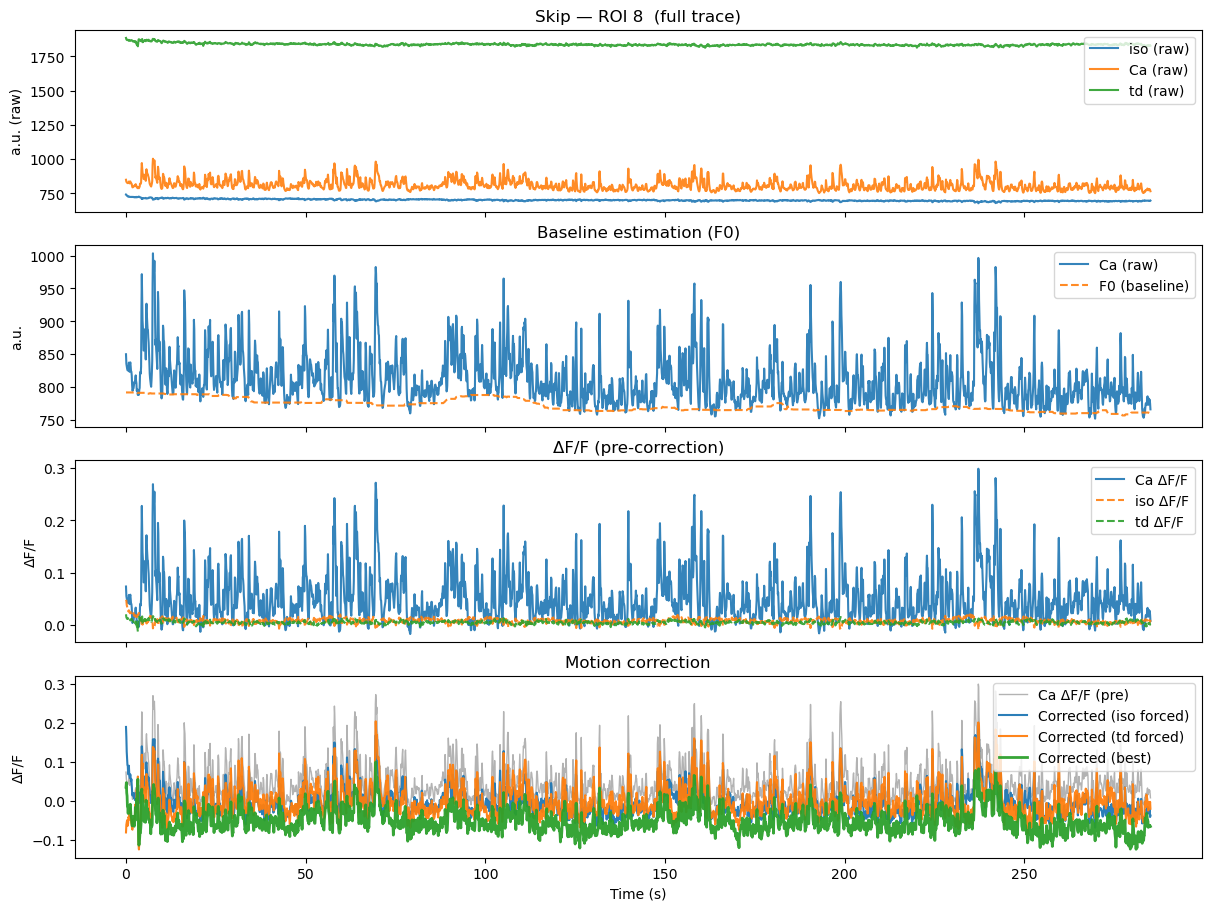

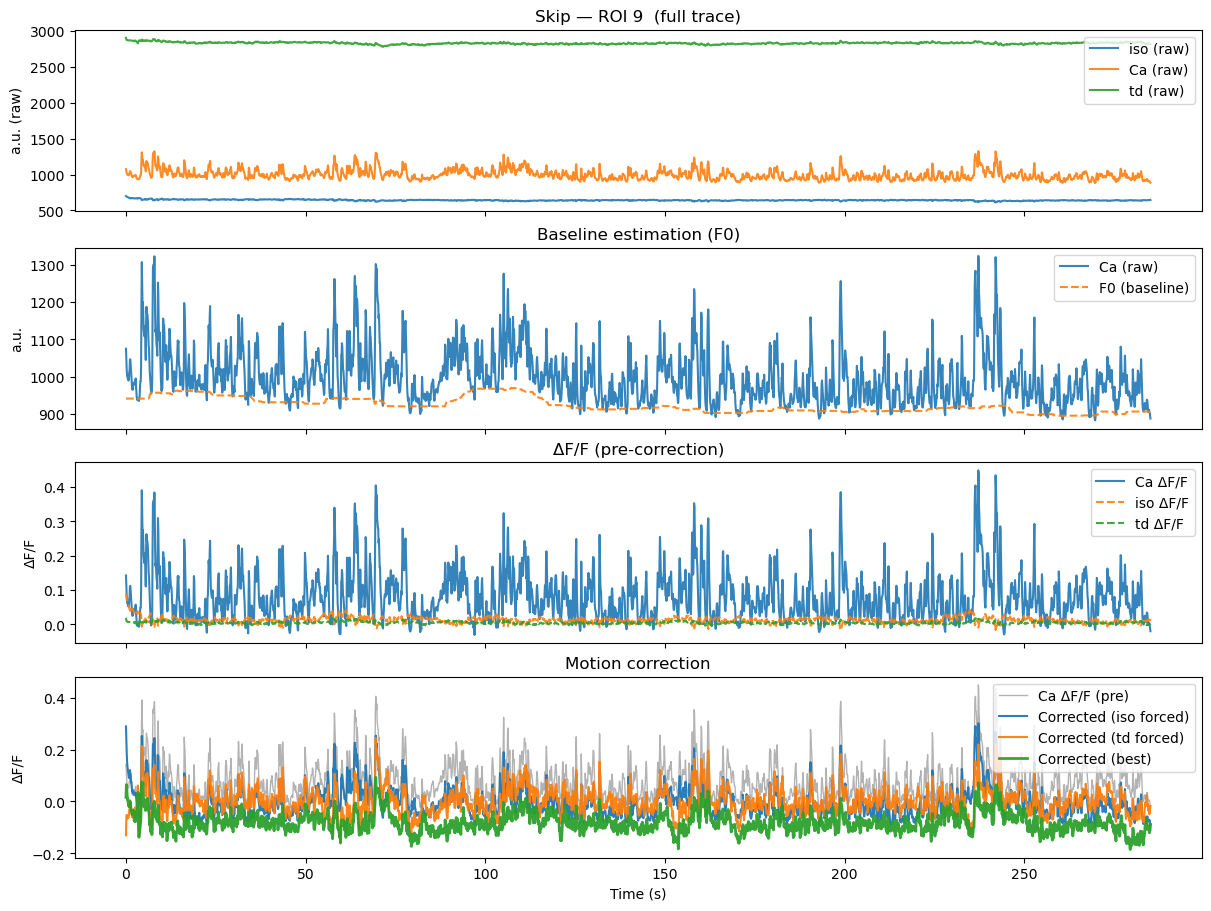

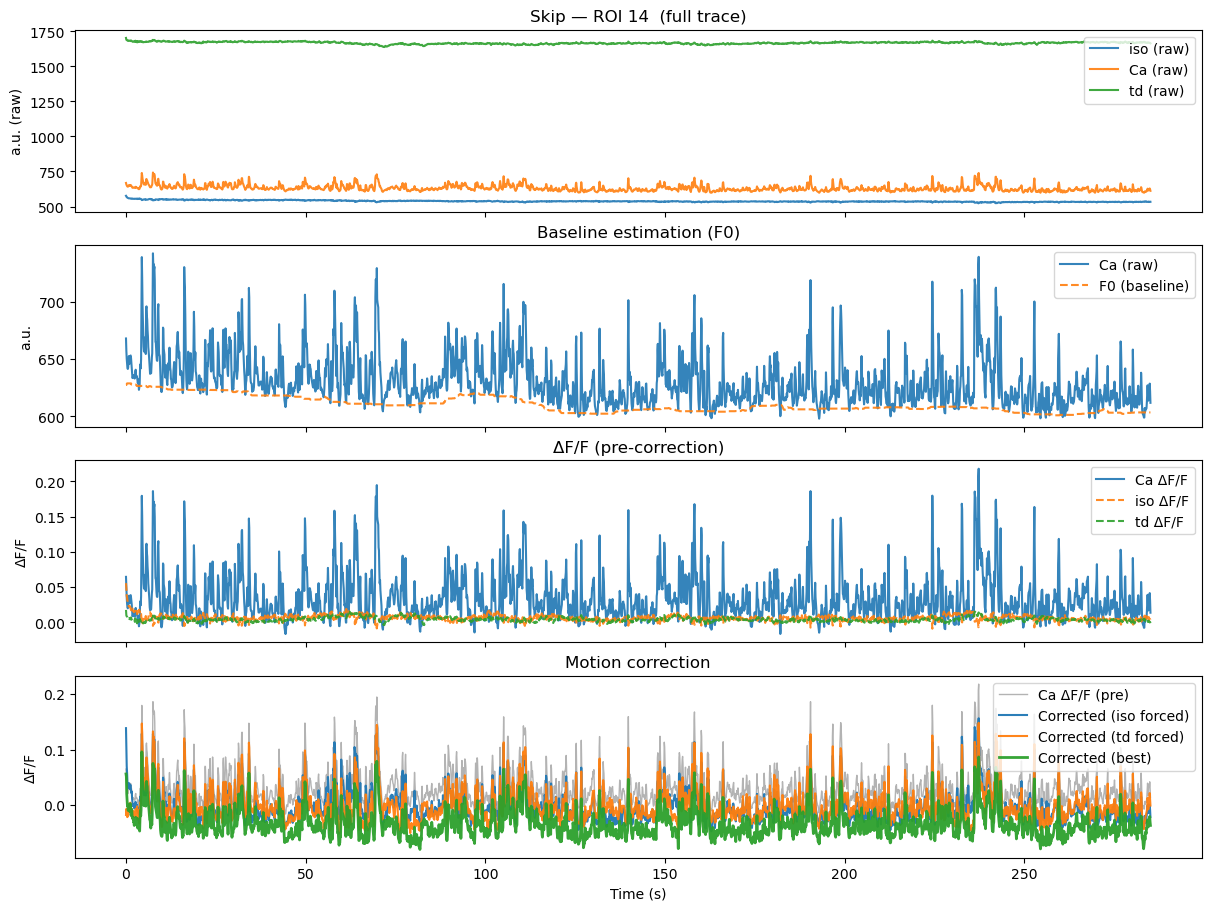

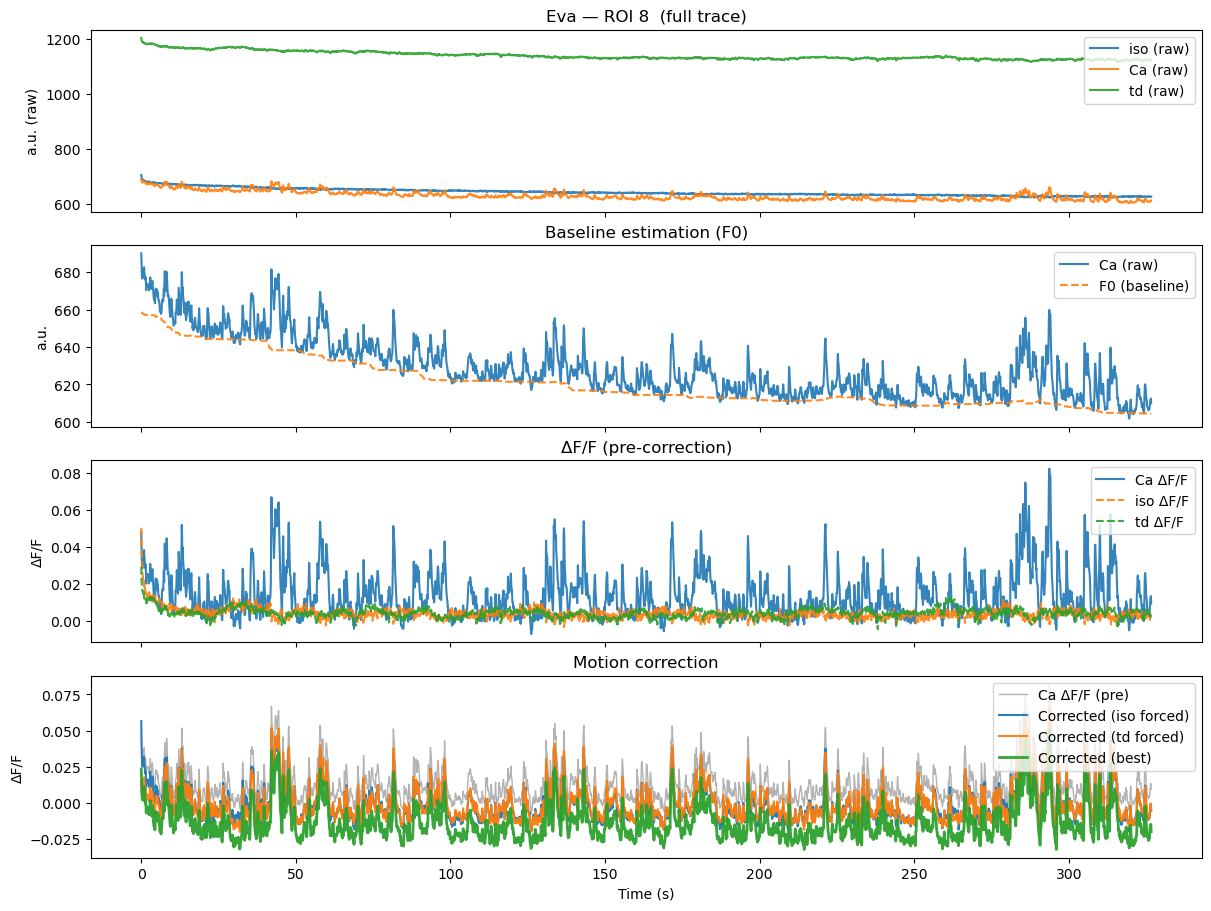

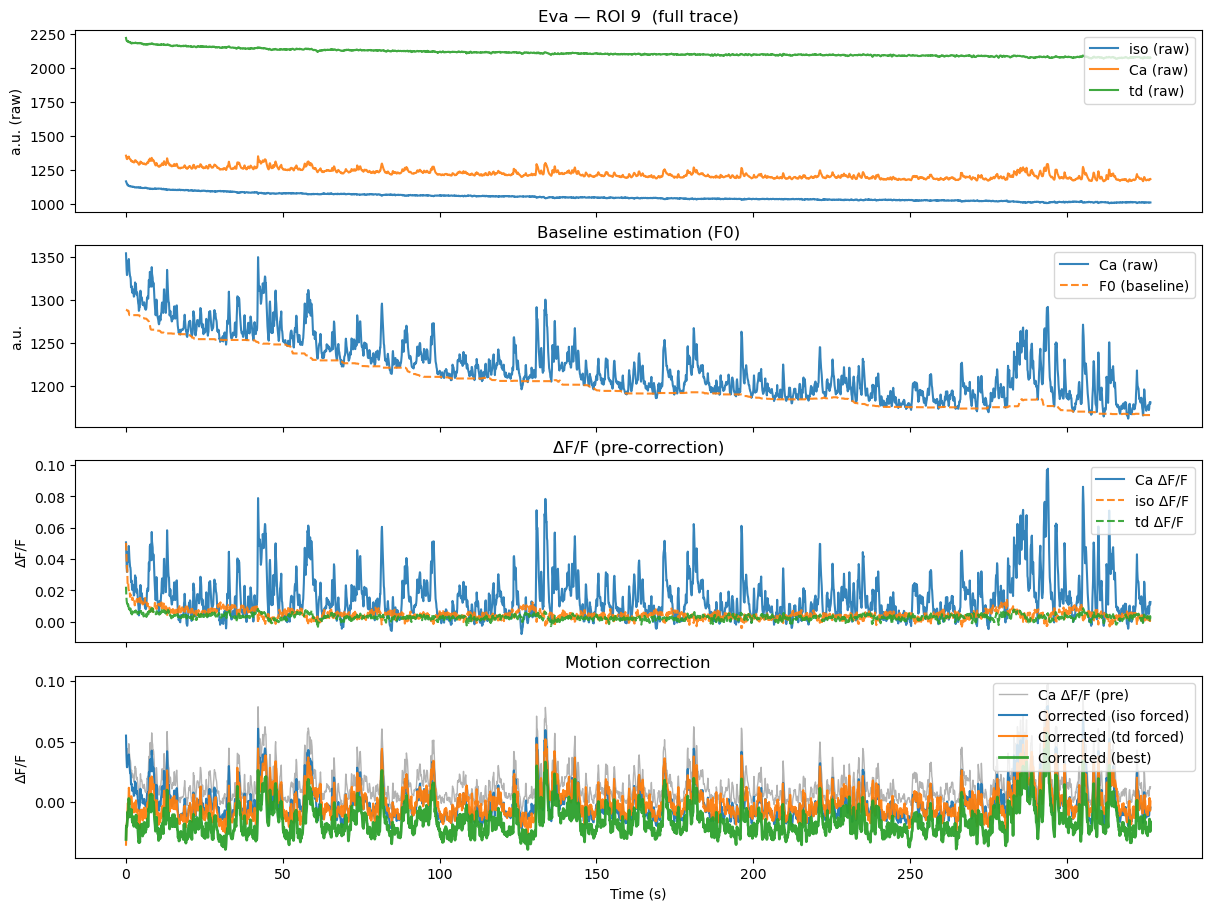

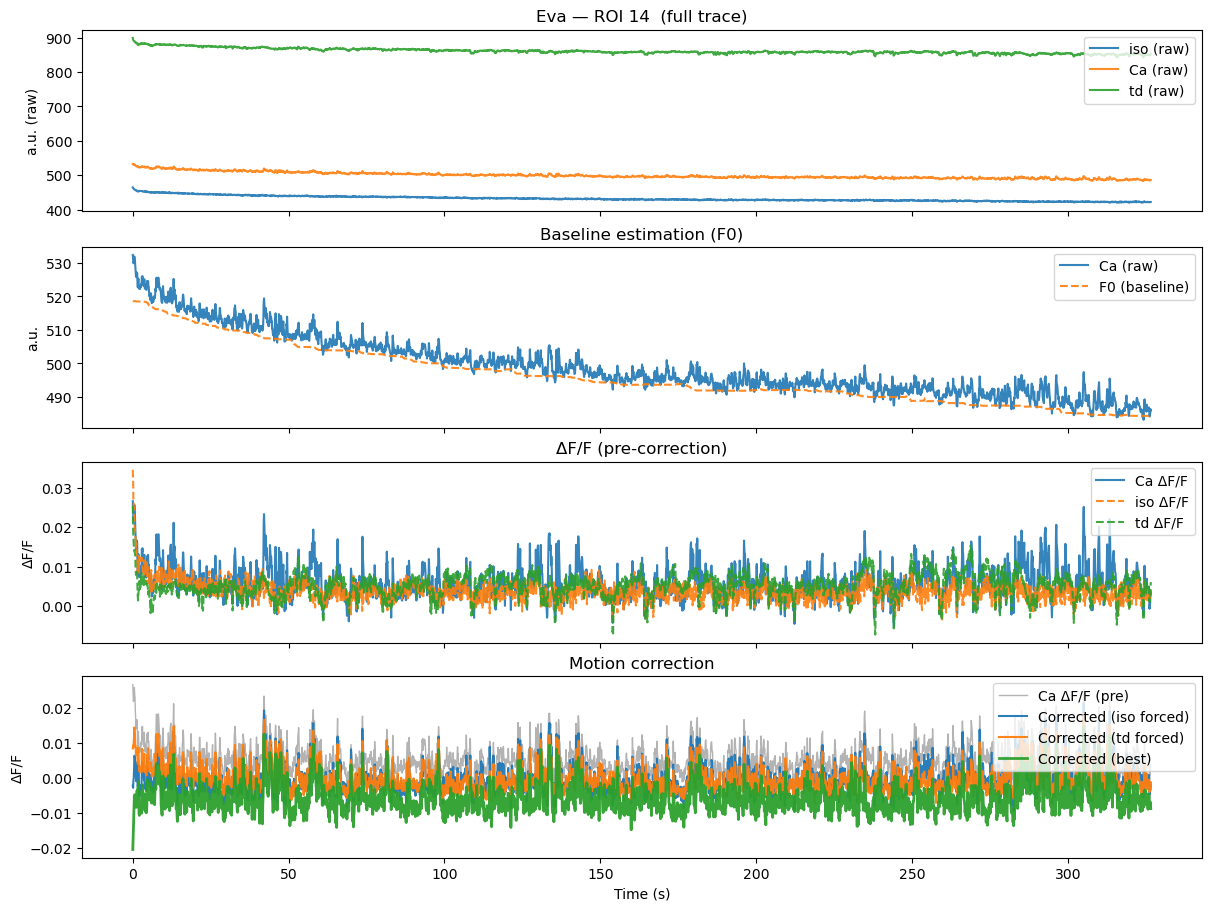

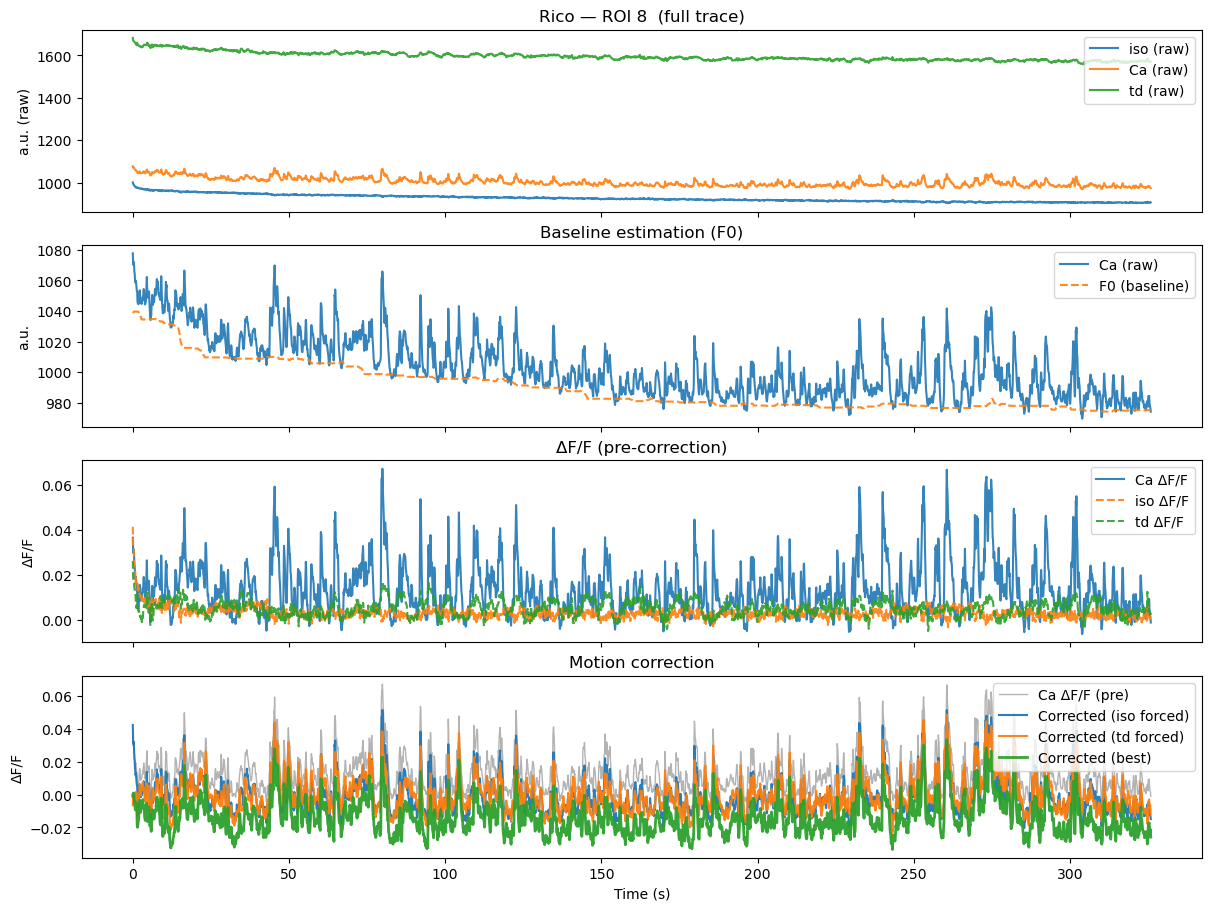

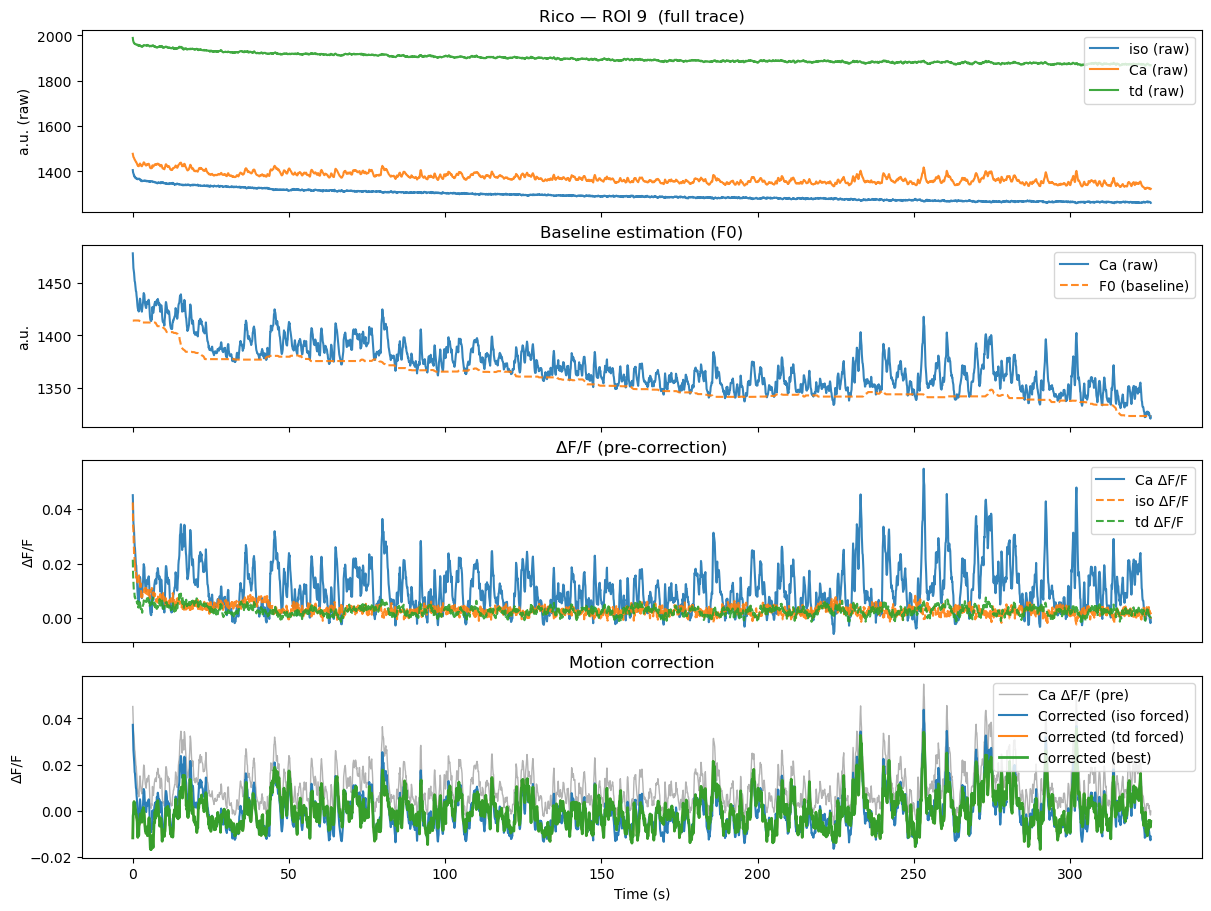

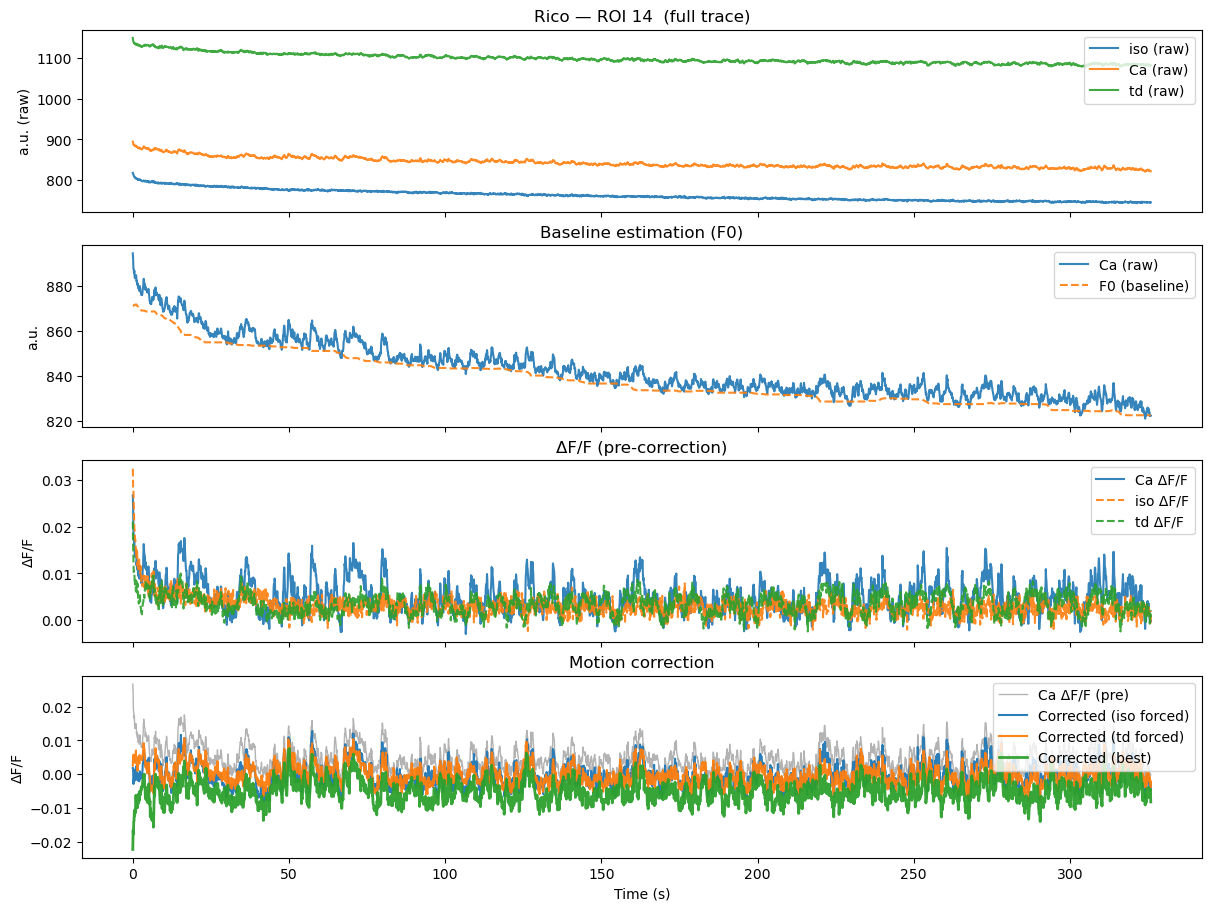

In [17]:
plot_preprocessing_panels(data, sessions = ['Skip', 'Eva', 'Rico'], rois=[8, 9, 14], t_window=None, normalize_raw=False)

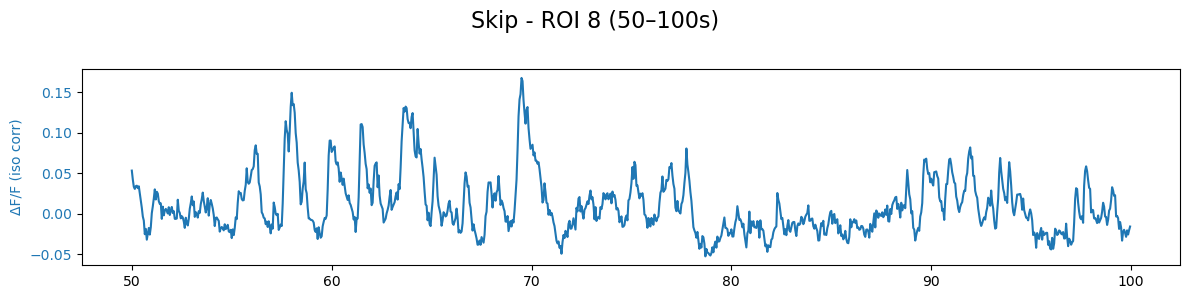

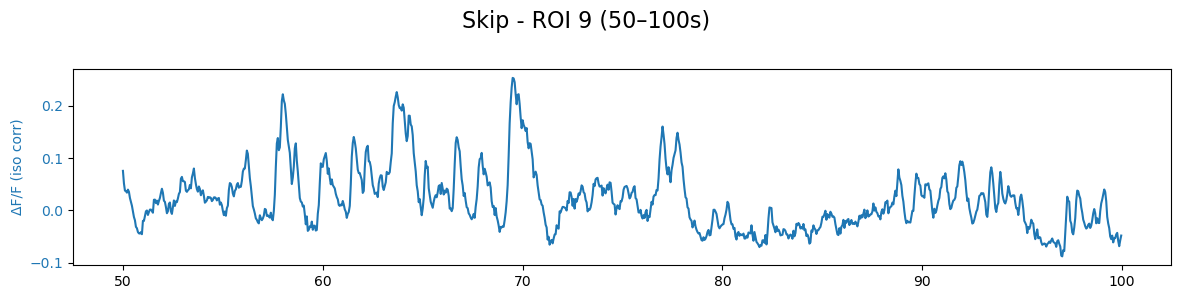

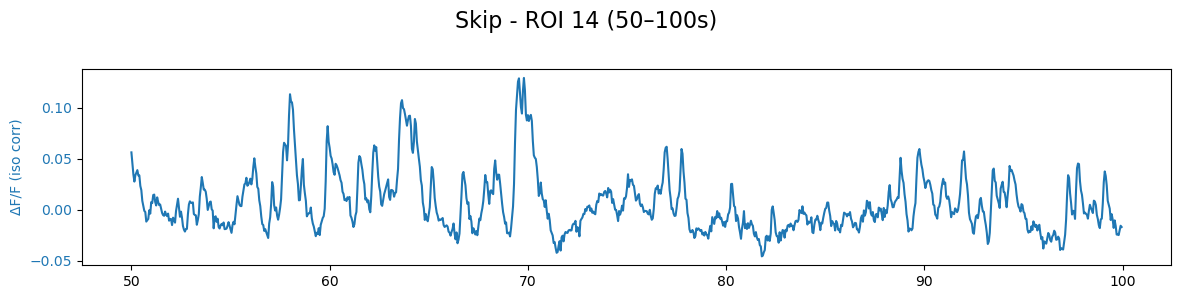

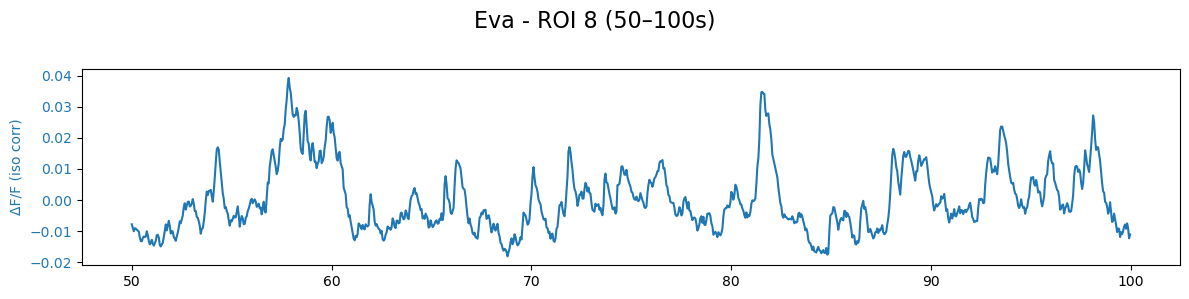

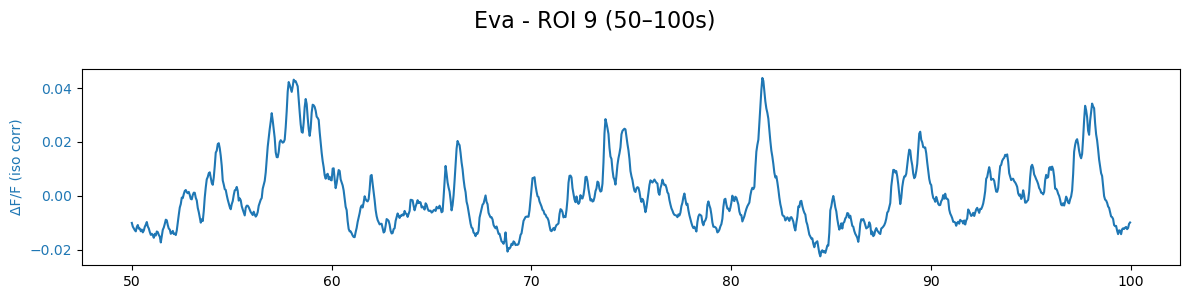

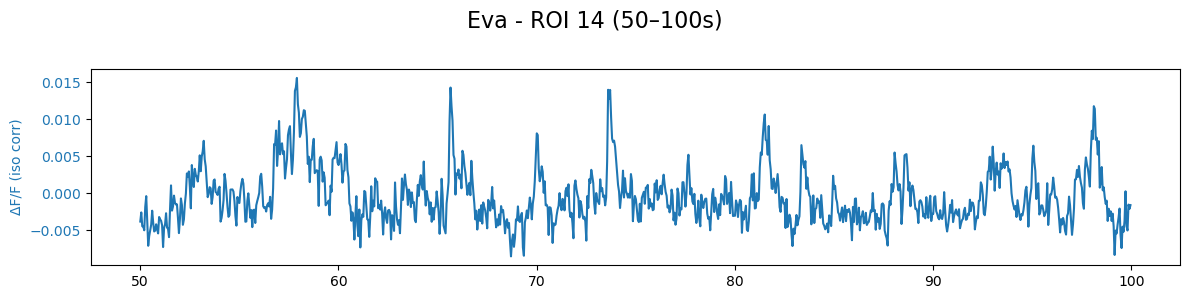

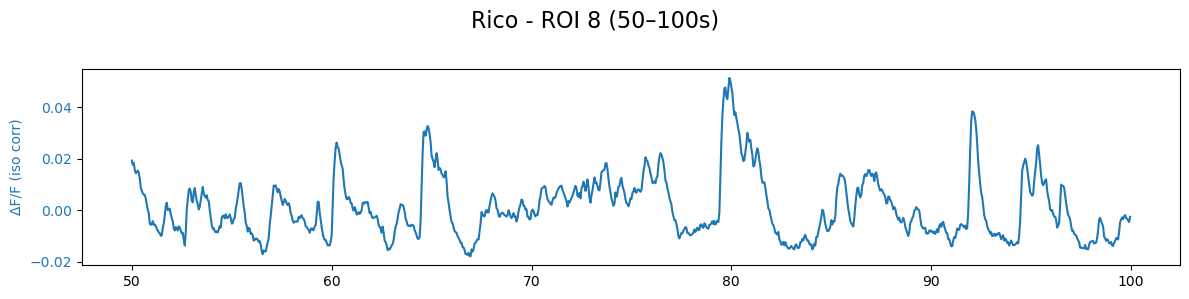

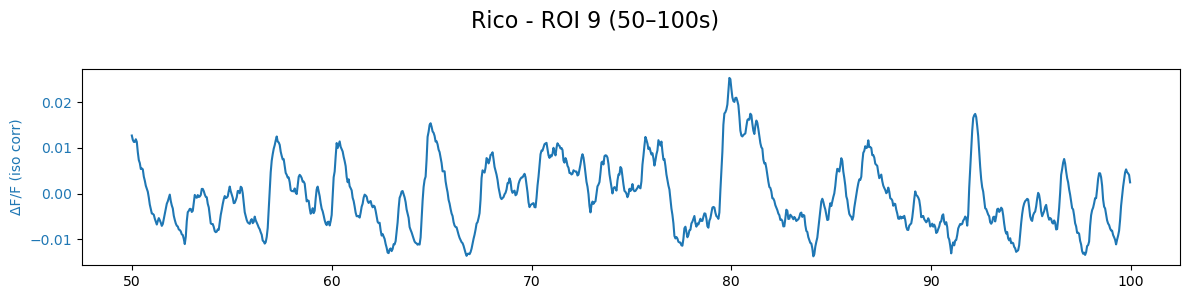

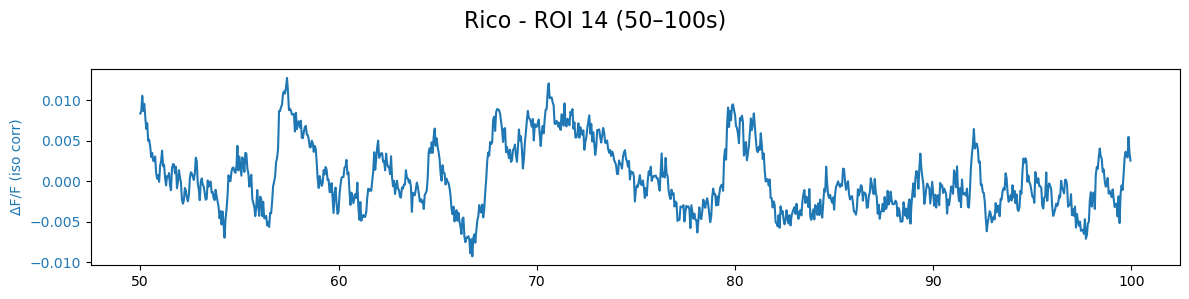

In [15]:

for session, results in data.items():
    #n_rois = results['time_interp'].shape[1]
    #rois = [0, 1, 4, 5, 7, 8, 9, 13, 14, 15, 16]
    rois = [8, 9, 14] 


    #for roi in range(n_rois):
    for roi in rois:
        t_ref = results['time_interp'][:, roi]
        iso = results['corrected_data_iso'][:, roi]
        td = results['corrected_data_td'][:,  roi]
        ca = results['fluo_interp'][:, 1, roi]    
        best = results['corrected_data_best'][:,  roi]

        start_sec, end_sec =50,100
        mask = (t_ref >= start_sec) & (t_ref <= end_sec)

        fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharex=True)

        axes.plot(t_ref[mask], iso[mask], color='tab:blue')
        axes.set_ylabel('ΔF/F (iso corr)', color='tab:blue')
        axes.tick_params(axis='y', labelcolor='tab:blue')

        fig.suptitle(f'{session} - ROI {roi} ({start_sec}–{end_sec}s)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
